<a href="https://colab.research.google.com/github/vivekbiju/XAI/blob/main/VGG16_XAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opencv-python
!pip install kagglehub
!pip install tensorflow
!pip install shap
!pip install tqdm

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16 # Change from ResNet50
from tensorflow.keras.applications.vgg16 import preprocess_input # Change from resnet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import random
import time
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
from tensorflow.keras.utils import to_categorical
import seaborn as sns
import kagglehub
import shap # For SHAP explanations
from tqdm import tqdm # For progress bars

Attempting to download dataset...
Path to dataset files: /kaggle/input/melanoma-cancer-dataset
Number of images benign: 7289
Number of images malignant: 6590


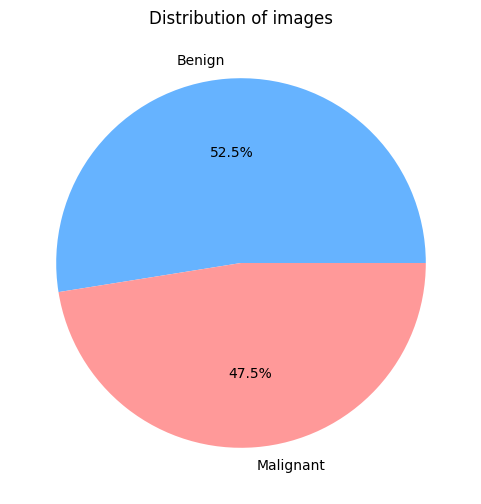


Visualizing sample Benign images...


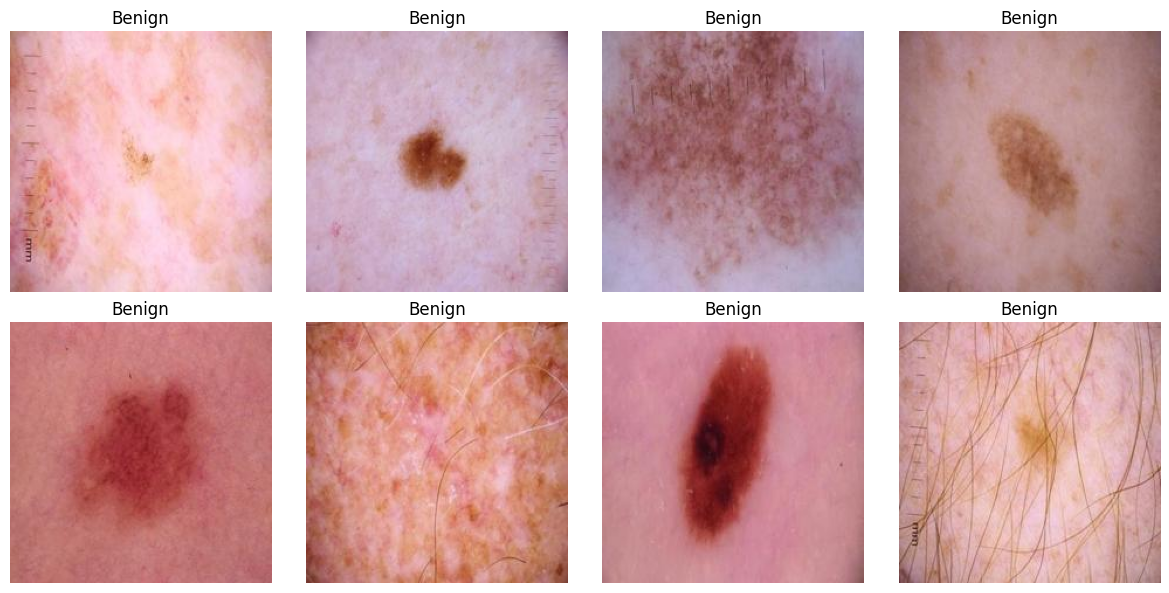


Visualizing sample Malignant images...


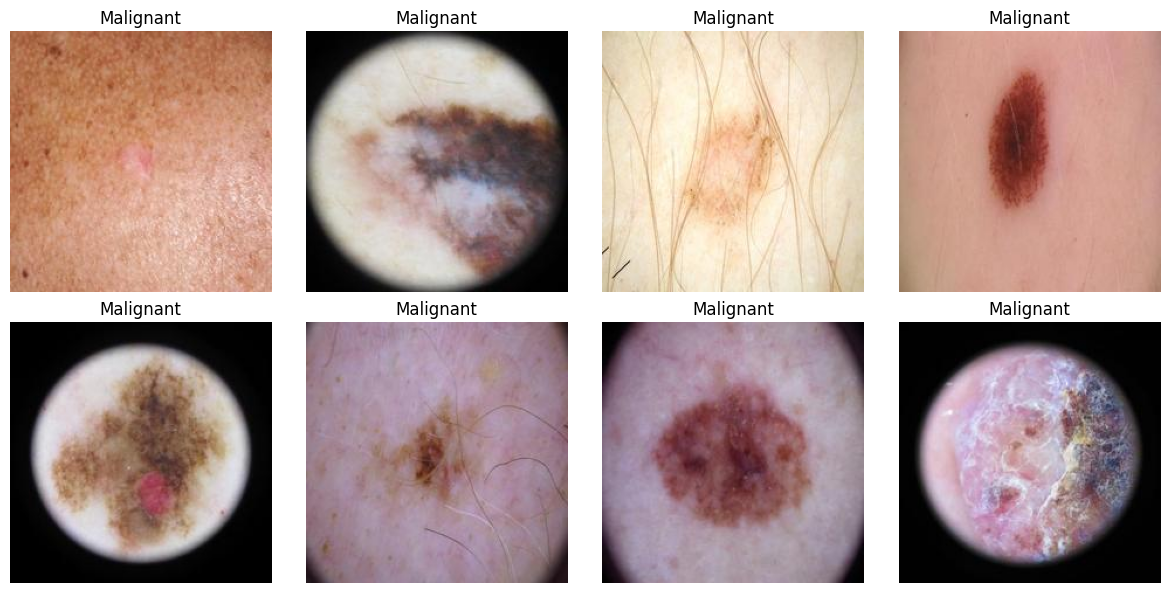

In [ ]:
# Set consistent random seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Define image dimensions as constants
IMG_HEIGHT = 224
IMG_WIDTH = 224

# Helper function for consistent image loading and preprocessing
# Note: preprocess_input will now be from VGG16, handling its specific scaling
def load_and_preprocess_single_image(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH)):
    """
    Loads, resizes, converts to RGB, and preprocesses a single image for model input.
    Args:
        img_path (str): Path to the image file.
        target_size (tuple): Desired (height, width) for resizing.
    Returns:
        tuple: (preprocessed_image_array (batch of 1), original_rgb_resized_image, original_full_size_image)
               Returns (None, None, None) if image cannot be loaded.
    """
    img_full_size = cv2.imread(img_path)
    if img_full_size is None:
        return None, None, None

    img_resized = cv2.resize(img_full_size, target_size)
    img_rgb_resized = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
    # Use VGG16's specific preprocess_input
    img_array_preprocessed = preprocess_input(np.expand_dims(img_rgb_resized, axis=0)) # Model input expects batch dim
    return img_array_preprocessed, img_rgb_resized, cv2.cvtColor(img_full_size, cv2.COLOR_BGR2RGB) # Return original RGB for display


# --------- Dataset Download & Paths ---------
print("Attempting to download dataset...")
try:
    path = kagglehub.dataset_download("bhaveshmittal/melanoma-cancer-dataset")
    print("Path to dataset files:", path)
except Exception as e:
    print(f"Error downloading dataset from Kaggle Hub: {e}")
    print("Please ensure kagglehub is installed and configured correctly.")
    exit_script = input("Dataset download failed. Do you want to exit the script? (y/n): ")
    if exit_script.lower() == 'y':
        exit()
    else:
        print("Proceeding without dataset. This will likely cause errors later.")
        path = "." # Fallback to current directory, likely empty

train_path = os.path.join(path, "train")
test_path = os.path.join(path, "test")

# Check if paths exist after download attempt
if not os.path.exists(train_path) or not os.path.exists(test_path):
    print(f"Error: Training or test path not found. Please ensure the dataset is downloaded correctly to '{path}'.")
    exit()

# --------- Count images ---------
ben = len(os.listdir(os.path.join(train_path, "Benign"))) + len(os.listdir(os.path.join(test_path, "Benign")))
mal = len(os.listdir(os.path.join(train_path, "Malignant"))) + len(os.listdir(os.path.join(test_path, "Malignant")))

print(f"Number of images benign: {ben}")
print(f"Number of images malignant: {mal}")

# --------- Pie chart for class distribution ---------
plt.figure(figsize=(6,6))
plt.pie([ben, mal], labels=['Benign', 'Malignant'], autopct='%1.1f%%', colors=['#66b3ff','#ff9999'])
plt.title("Distribution of images")
plt.show()

# --------- Visualize sample images ---------
print("\nVisualizing sample Benign images...")
plt.figure(figsize=(12, 6))
benign_sample_images = [f for f in os.listdir(os.path.join(train_path, 'Benign')) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
for i, img_name in enumerate(benign_sample_images[:8]):
    img_path = os.path.join(train_path, 'Benign', img_name)
    _, img_rgb_display, _ = load_and_preprocess_single_image(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    if img_rgb_display is not None:
        plt.subplot(2, 4, i + 1)
        plt.imshow(img_rgb_display) # Display the RGB image directly
        plt.title("Benign")
        plt.axis('off')
plt.tight_layout()
plt.show()

print("\nVisualizing sample Malignant images...")
plt.figure(figsize=(12, 6))
malignant_sample_images = [f for f in os.listdir(os.path.join(train_path, 'Malignant')) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
for i, img_name in enumerate(malignant_sample_images[:8]):
    img_path = os.path.join(train_path, 'Malignant', img_name)
    _, img_rgb_display, _ = load_and_preprocess_single_image(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    if img_rgb_display is not None:
        plt.subplot(2, 4, i + 1)
        plt.imshow(img_rgb_display) # Display the RGB image directly
        plt.title("Malignant")
        plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# --------- Data Generators ---------
print("\nSetting up data generators...")
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input, # VGG16's preprocess_input
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.1,
    horizontal_flip=True,
)

valid_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input, # VGG16's preprocess_input
    validation_split=0.2
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input) # VGG16's preprocess_input

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode='rgb',
    shuffle=True,
    subset="training",
    class_mode='categorical',
    batch_size=32,
    seed=42
)

valid_generator = valid_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    subset="validation",
    class_mode='categorical',
    batch_size=32,
    color_mode='rgb',
    shuffle=False,
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    shuffle=False,
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb',
    seed=42
)

# --------- Build model with VGG16 base ---------
print("\nBuilding VGG16-based model...")
vgg = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
)
vgg.trainable = False # Start with freezing the base model

model = tf.keras.Sequential([
    vgg, # VGG16 base model
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='softmax', kernel_regularizer=l2(0.01)) # 2 classes: Benign, Malignant
])

model.summary()

# --------- Optimizer and Callbacks ---------
optimizer = Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=1e-7,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5, # Increased patience for better convergence
    restore_best_weights=True,
    verbose=1
)

callbacks = [reduce_lr, early_stopping]

# --------- Train the model (Feature Extraction) ---------
print("\nStarting initial model training (feature extraction)...")
start_time = time.time()
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=3, # Increased epochs, EarlyStopping will manage convergence
    callbacks=callbacks
)
end_time = time.time()
total_time = end_time - start_time
hours, rem = divmod(total_time, 3600)
minutes, seconds = divmod(rem, 60)
print(f"\nTotal initial training time: {int(hours)}h {int(minutes)}m {int(seconds)}s")

# --------- Fine-tuning ---------
print("\nStarting fine-tuning of the model...")
vgg.trainable = True # Unfreeze the base model
# Freeze early layers to retain low-level features
# VGG16 has 19 layers (conv/pool blocks). Adjust this number carefully.
# For example, freezing up to 'block4_pool' or 'block3_pool' is common.
# 'block5_conv1' is a common starting point to unfreeze.
for layer in vgg.layers[:15]: # Example: freezing up to block4_pool
    layer.trainable = False

optimizer_finetune = Adam(learning_rate=1e-5) # Lower learning rate for fine-tuning
model.compile(optimizer=optimizer_finetune, loss='categorical_crossentropy', metrics=['accuracy'])

history_finetune = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=3, # Increased epochs, EarlyStopping will manage convergence
    callbacks=callbacks
)

# Save the trained model
model_save_path = "vgg16_melanoma_detection_model.h5" # Changed model name
try:
    model.save(model_save_path)
    print(f"\nModel saved successfully at: {model_save_path}")
except Exception as e:
    print(f"Error saving model: {e}")


Setting up data generators...
Found 9504 images belonging to 2 classes.
Found 2375 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.

Building VGG16-based model...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │         8,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,722,930 (56.16 MB)

 Trainable params: 8,242 (32.20 KB)

 Non-trainable params: 14,714,688 (56.13 MB)


Starting initial model training (feature extraction)...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
297/297 ━━━━━━━━━━━━━━━━━━━━ 178s 598ms/step - accuracy: 0.6390 - loss: 1.0589 - val_accuracy: 0.7171 - val_loss: 0.8582 - learning_rate: 1.0000e-04
Epoch 2/3
297/297 ━━━━━━━━━━━━━━━━━━━━ 177s 596ms/step - accuracy: 0.7323 - loss: 0.8017 - val_accuracy: 0.7562 - val_loss: 0.7865 - learning_rate: 1.0000e-04
Epoch 3/3
297/297 ━━━━━━━━━━━━━━━━━━━━ 177s 597ms/step - accuracy: 0.7838 - loss: 0.7041 - val_accuracy: 0.7731 - val_loss: 0.7237 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 3.

Total initial training time: 0h 8m 53s

Starting fine-tuning of the model...
Epoch 1/3
297/297 ━━━━━━━━━━━━━━━━━━━━ 195s 652ms/step - accuracy: 0.8189 - loss: 0.6195 - val_accuracy: 0.8046 - val_loss: 0.6487 - learning_rate: 1.0000e-05
Epoch 2/3
297/297 ━━━━━━━━━━━━━━━━━━━━ 193s 651ms/step - accuracy: 0.8477 - loss: 0.5329 - val_accuracy: 0.8122 - val_loss: 0.6081 - learning_rate: 1.0000e-05
Epoch 3/3
297/297 ━━━━━━━━━━━━━━━━━━━━ 193s 650ms/step - accuracy: 0


Model saved successfully at: vgg16_melanoma_detection_model.h5


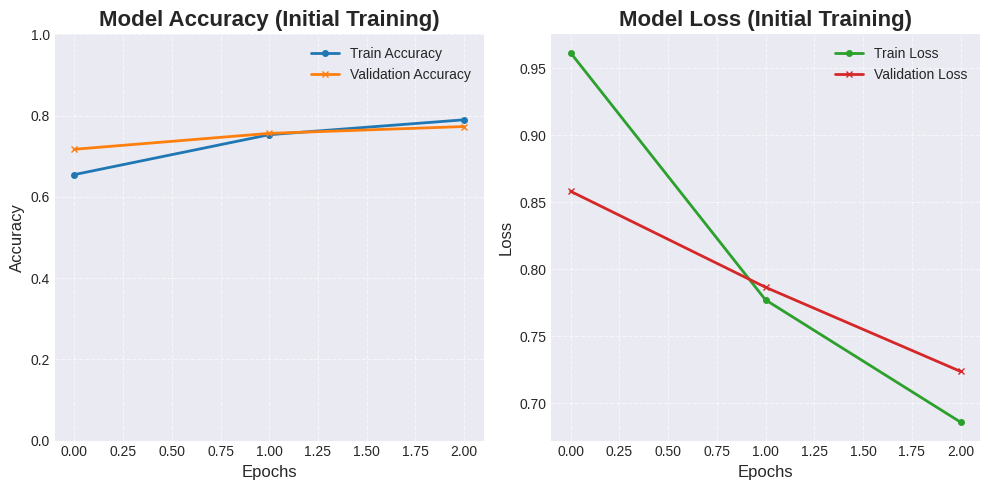

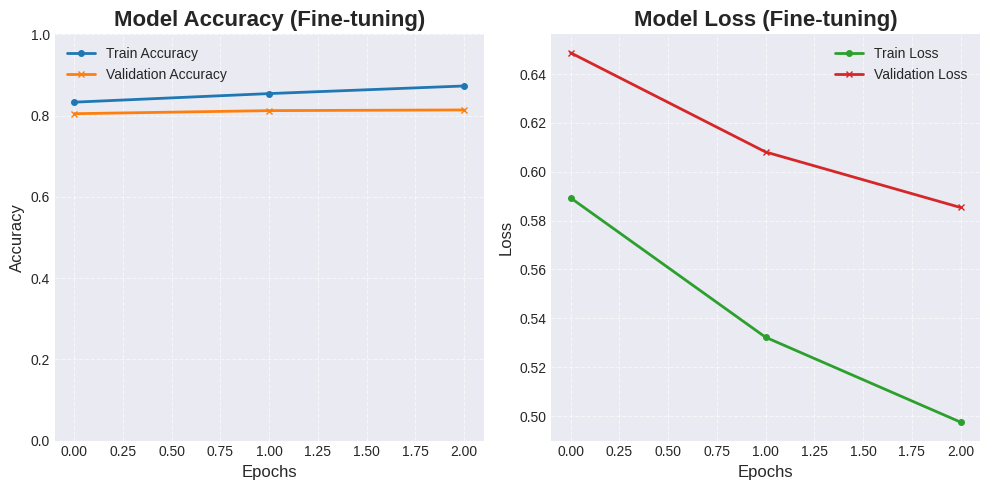


Evaluating model on the test set...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 441ms/step - accuracy: 0.9323 - loss: 0.4056
Test Accuracy: 85.20%
Test Loss: 0.5315
63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 443ms/step


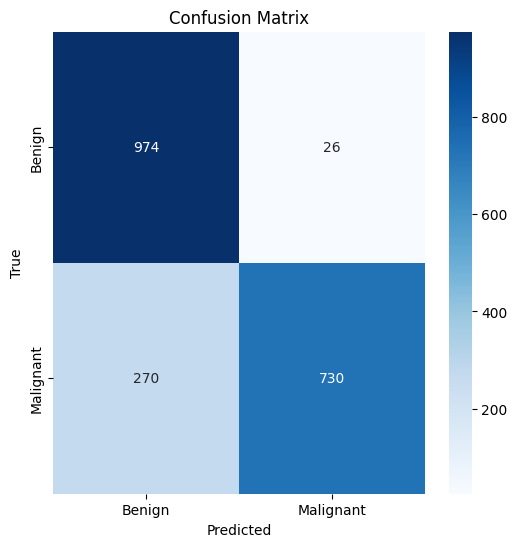

Classification Report:

              precision    recall  f1-score   support

      Benign       0.78      0.97      0.87      1000
   Malignant       0.97      0.73      0.83      1000

    accuracy                           0.85      2000
   macro avg       0.87      0.85      0.85      2000
weighted avg       0.87      0.85      0.85      2000



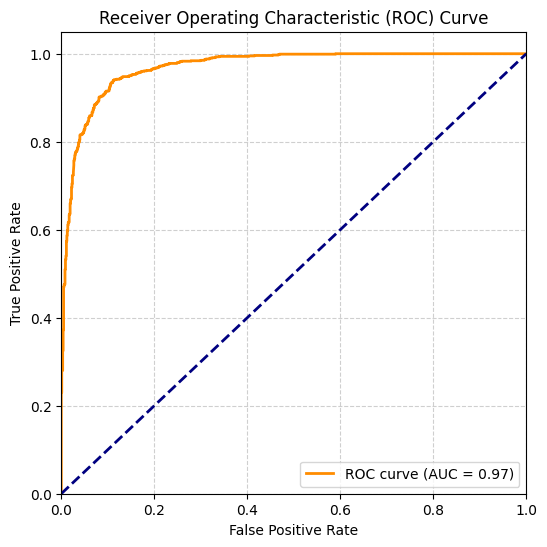

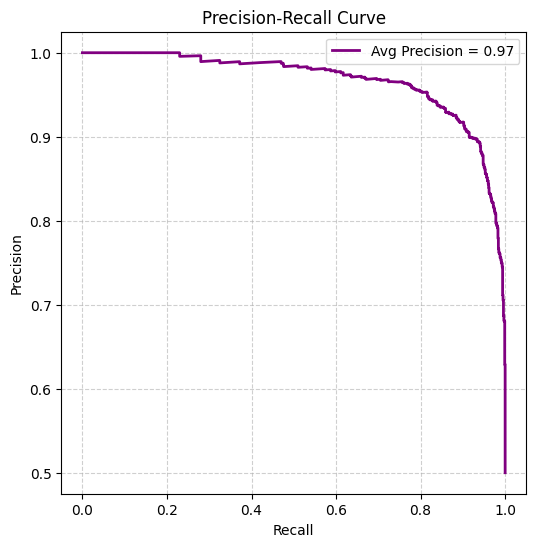

In [ ]:
# --------- Plot training & validation accuracy and loss (Professional Version) ---------
def plot_training(history_obj, title_suffix=""):
    """
    Plots training and validation accuracy and loss in a professional manner.

    Args:
        history_obj: Keras History object containing training logs.
        title_suffix (str): Suffix to add to the plot titles (e.g., "(Initial Training)").
    """
    plt.style.use('seaborn-v0_8-darkgrid') # Use a professional style with dark grid
    plt.figure(figsize=(10, 5)) # Slightly larger figure for better readability

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history_obj.history['accuracy'], label='Train Accuracy', color='#1f77b4', marker='o', markersize=4, linewidth=2)
    plt.plot(history_obj.history['val_accuracy'], label='Validation Accuracy', color='#ff7f0e', marker='x', markersize=4, linewidth=2)
    plt.title(f"Model Accuracy {title_suffix}", fontsize=16, fontweight='bold')
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.6) # Enhanced gridlines
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.ylim([0, 1]) # Ensure y-axis for accuracy is from 0 to 1

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history_obj.history['loss'], label='Train Loss', color='#2ca02c', marker='o', markersize=4, linewidth=2)
    plt.plot(history_obj.history['val_loss'], label='Validation Loss', color='#d62728', marker='x', markersize=4, linewidth=2)
    plt.title(f"Model Loss {title_suffix}", fontsize=16, fontweight='bold')
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.6) # Enhanced gridlines
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout() # Adjust layout to prevent overlapping
    plt.show()
    plt.style.use('default') # Revert to default style for subsequent plots if desired

plot_training(history, "(Initial Training)")
plot_training(history_finetune, "(Fine-tuning)")

print("\nEvaluating model on the test set...")
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

test_generator.reset()
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes # This variable is crucial for Grad-CAM and SHAP

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# --------- ROC Curve ---------
# Convert labels to categorical if binary
if y_pred_probs.shape[1] == 2:
    y_true_categorical = to_categorical(y_true, num_classes=2)
    fpr, tpr, thresholds = roc_curve(y_true_categorical[:,1], y_pred_probs[:,1])
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

# --------- Precision-Recall Curve ---------
precision, recall, thresholds_pr = precision_recall_curve(y_true_categorical[:,1], y_pred_probs[:,1])
average_precision = average_precision_score(y_true_categorical[:,1], y_pred_probs[:,1])

plt.figure(figsize=(6,6))
plt.plot(recall, precision, color='purple', lw=2, label=f'Avg Precision = {average_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()



Visualizing sample predictions from the test set...
63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 437ms/step


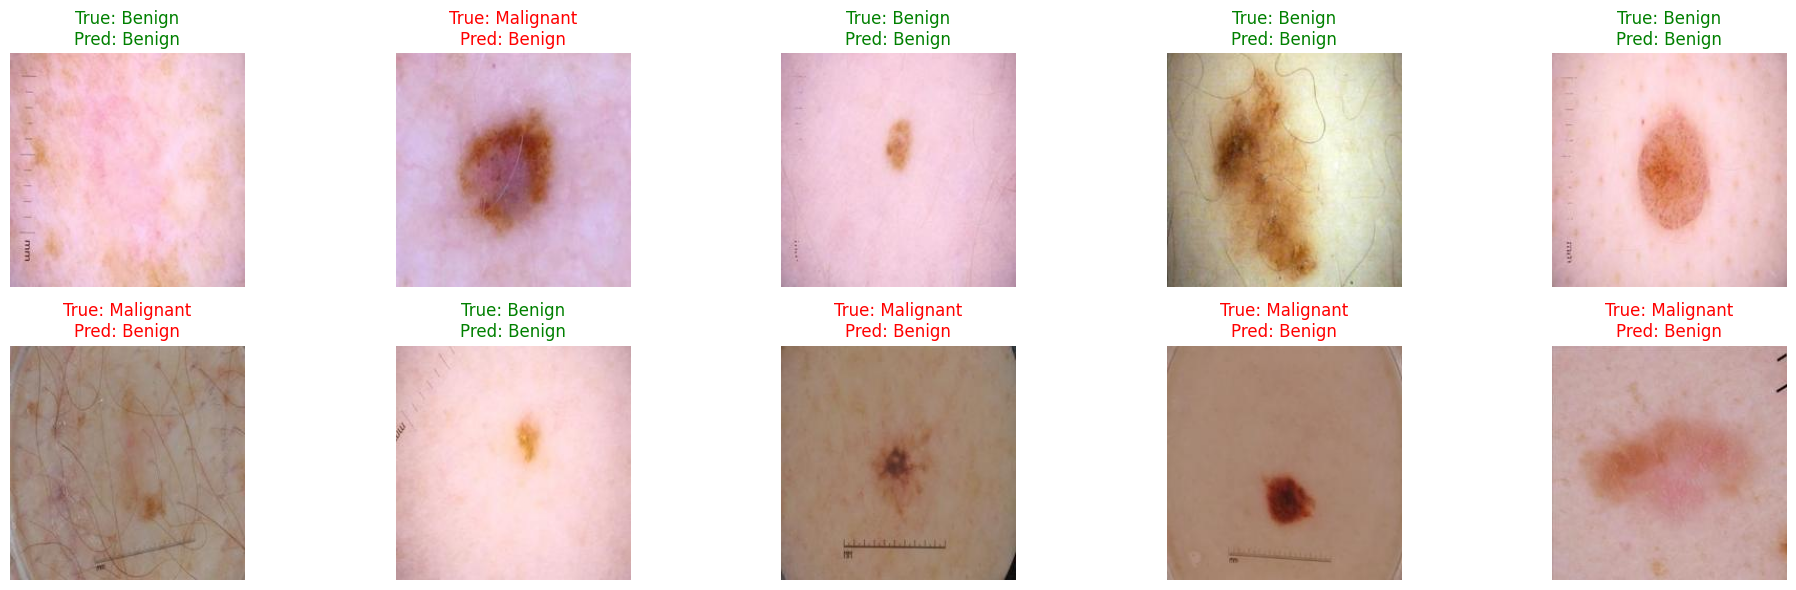

In [ ]:
# --------- Prediction and Visualisation (Random Samples) ---------
def visualise_predictions(model, generator, class_names, num_images=10):
    """
    Visualises predictions for a few images from a generator, prioritizing misclassified.
    Args:
        model: Trained Keras model.
        generator: Keras ImageDataGenerator.
        class_names (list): List of class names.
        num_images (int): Number of images to visualise.
    """
    generator.reset() # Ensure fresh start
    true_labels_arr = generator.classes
    pred_labels_arr = np.argmax(model.predict(generator), axis=1)

    correct_indices = np.where(true_labels_arr == pred_labels_arr)[0]
    incorrect_indices = np.where(true_labels_arr != pred_labels_arr)[0]

    selected_indices = []
    # Prioritize misclassified samples
    num_incorrect_to_pick = min(num_images // 2, len(incorrect_indices))
    num_correct_to_pick = min(num_images - num_incorrect_to_pick, len(correct_indices))

    selected_indices.extend(random.sample(list(incorrect_indices), num_incorrect_to_pick))
    selected_indices.extend(random.sample(list(correct_indices), num_correct_to_pick))
    random.shuffle(selected_indices) # Shuffle to mix order

    if not selected_indices:
        print("No images to visualize (dataset might be empty or no predictions made).")
        return

    plt.figure(figsize=(20, 3 * (num_images // 5 + (1 if num_images % 5 != 0 else 0)))) # Adjust height for more rows
    for i, idx in enumerate(selected_indices[:num_images]):
        img_path = generator.filepaths[idx]
        _, img_rgb_display, _ = load_and_preprocess_single_image(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))

        if img_rgb_display is None:
            print(f"Could not load image {img_path}. Skipping.")
            continue

        # Normalize for display [0,1]
        img_display_norm = img_rgb_display.astype(np.float32) / 255.0

        true_label = class_names[true_labels_arr[idx]]
        predicted_label = class_names[pred_labels_arr[idx]]

        plt.subplot(num_images // 5 + (1 if num_images % 5 != 0 else 0), 5, i + 1)
        plt.imshow(img_display_norm)
        color = "green" if true_label == predicted_label else "red"
        plt.title(f"True: {true_label}\nPred: {predicted_label}", color=color)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Get class names from test generator
class_names = list(test_generator.class_indices.keys())

# Visualise predictions
print("\nVisualizing sample predictions from the test set...")
visualise_predictions(model, test_generator, class_names, num_images=10)


--- Starting Grad-CAM Explanations ---

63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 441ms/step
Attempting to visualize 10 images with Grad-CAM (prioritizing misclassified).


Generating Grad-CAMs:   0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


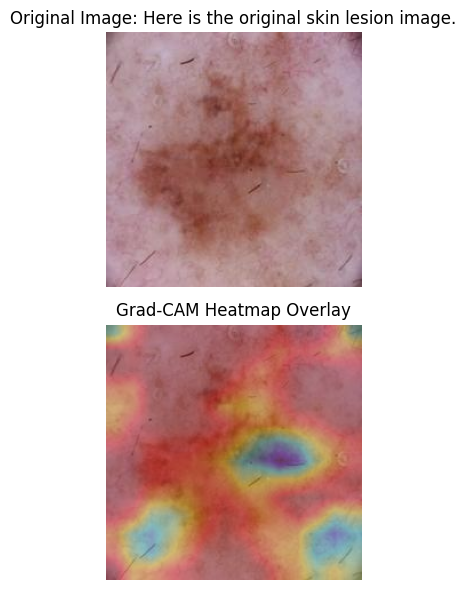

Generating Grad-CAMs:  10%|█         | 1/10 [00:00<00:05,  1.67it/s]

Heatmap Overlaid on Image: "The model focused on these areas (in red/yellow) to make its prediction."
Explanation: "The model predicts this lesion as Malignant with a confidence of 75.79%. The red regions represent areas that the model believes to be most indicative of malignant tissue. These areas may correspond to the irregular texture, shape, or color associated with cancerous tissue."
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


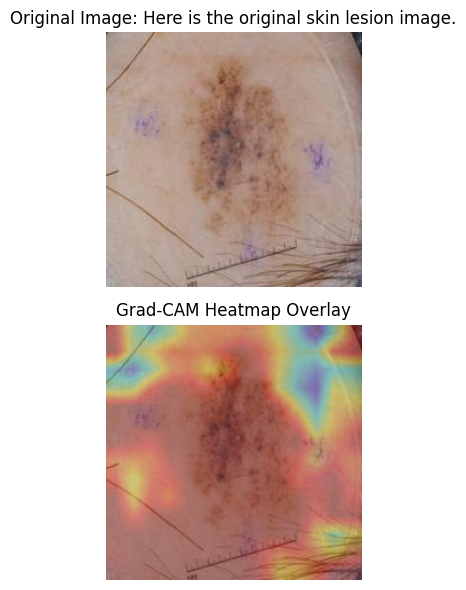

Generating Grad-CAMs:  20%|██        | 2/10 [00:01<00:04,  1.98it/s]

Heatmap Overlaid on Image: "The model focused on these areas (in red/yellow) to make its prediction."
Explanation: "The model predicts this lesion as Benign with a confidence of 51.70%. The red regions represent areas that the model believes to be most indicative of benign tissue. These areas may correspond to the irregular texture, shape, or color associated with cancerous tissue."
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


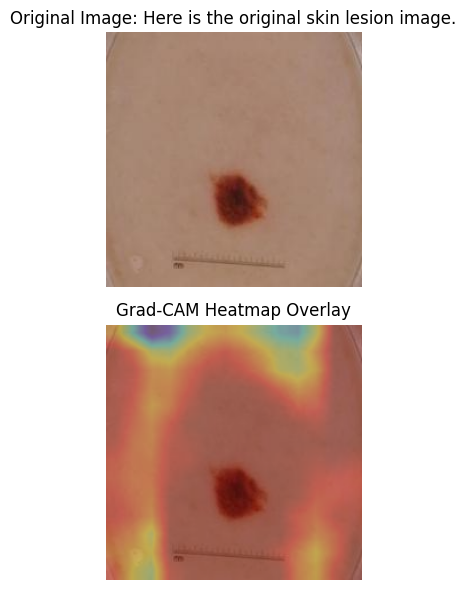

Generating Grad-CAMs:  30%|███       | 3/10 [00:01<00:03,  2.16it/s]

Heatmap Overlaid on Image: "The model focused on these areas (in red/yellow) to make its prediction."
Explanation: "The model predicts this lesion as Benign with a confidence of 53.33%. The red regions represent areas that the model believes to be most indicative of benign tissue. These areas may correspond to the irregular texture, shape, or color associated with cancerous tissue."
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


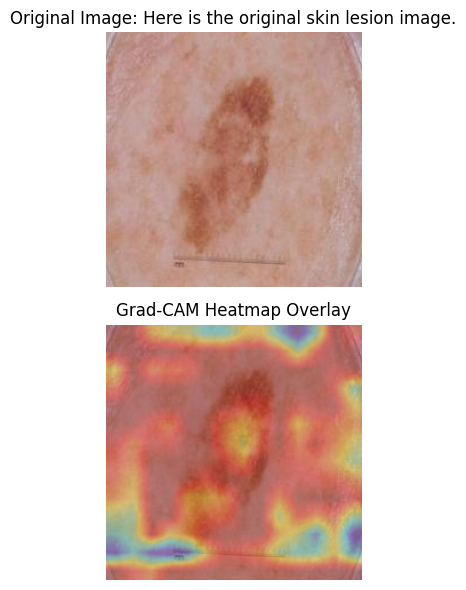

Generating Grad-CAMs:  40%|████      | 4/10 [00:01<00:02,  2.20it/s]

Heatmap Overlaid on Image: "The model focused on these areas (in red/yellow) to make its prediction."
Explanation: "The model predicts this lesion as Benign with a confidence of 52.70%. The red regions represent areas that the model believes to be most indicative of benign tissue. These areas may correspond to the irregular texture, shape, or color associated with cancerous tissue."
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


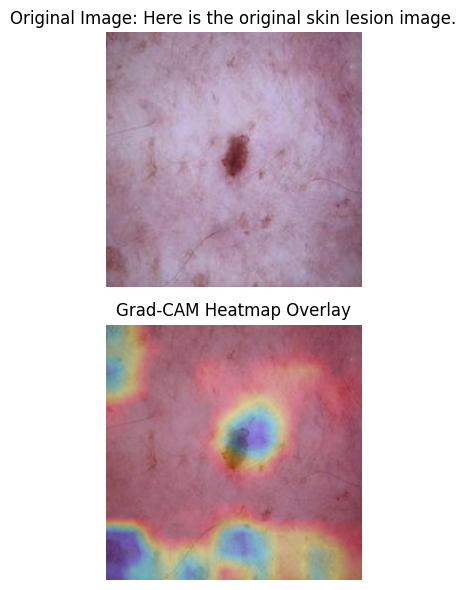

Generating Grad-CAMs:  50%|█████     | 5/10 [00:02<00:02,  2.23it/s]

Heatmap Overlaid on Image: "The model focused on these areas (in red/yellow) to make its prediction."
Explanation: "The model predicts this lesion as Malignant with a confidence of 53.26%. The red regions represent areas that the model believes to be most indicative of malignant tissue. These areas may correspond to the irregular texture, shape, or color associated with cancerous tissue."
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


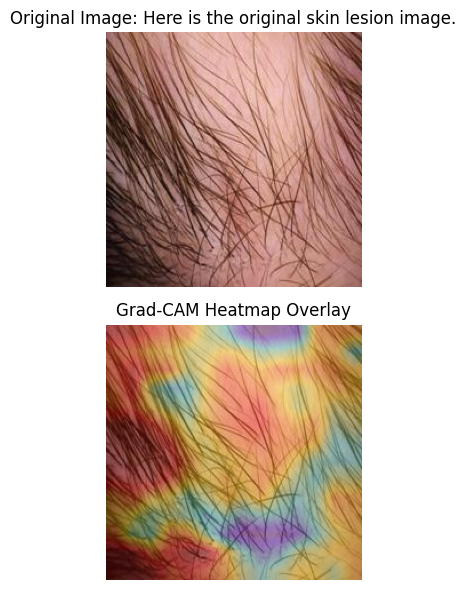

Generating Grad-CAMs:  60%|██████    | 6/10 [00:02<00:01,  2.26it/s]

Heatmap Overlaid on Image: "The model focused on these areas (in red/yellow) to make its prediction."
Explanation: "The model predicts this lesion as Benign with a confidence of 98.33%. The red regions represent areas that the model believes to be most indicative of benign tissue. These areas may correspond to the irregular texture, shape, or color associated with cancerous tissue."
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


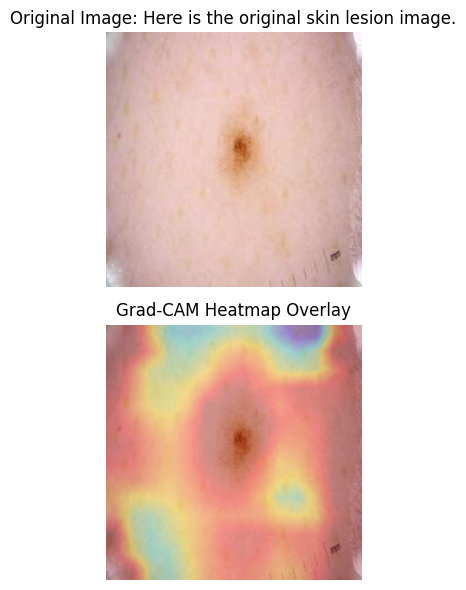

Generating Grad-CAMs:  70%|███████   | 7/10 [00:03<00:01,  2.28it/s]

Heatmap Overlaid on Image: "The model focused on these areas (in red/yellow) to make its prediction."
Explanation: "The model predicts this lesion as Benign with a confidence of 95.63%. The red regions represent areas that the model believes to be most indicative of benign tissue. These areas may correspond to the irregular texture, shape, or color associated with cancerous tissue."
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


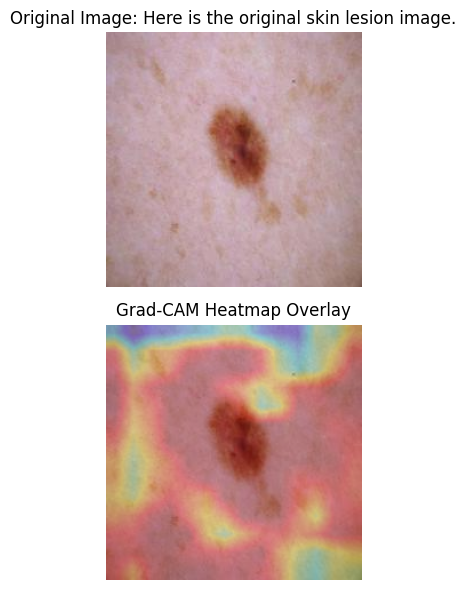

Generating Grad-CAMs:  80%|████████  | 8/10 [00:03<00:00,  2.28it/s]

Heatmap Overlaid on Image: "The model focused on these areas (in red/yellow) to make its prediction."
Explanation: "The model predicts this lesion as Benign with a confidence of 58.91%. The red regions represent areas that the model believes to be most indicative of benign tissue. These areas may correspond to the irregular texture, shape, or color associated with cancerous tissue."
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


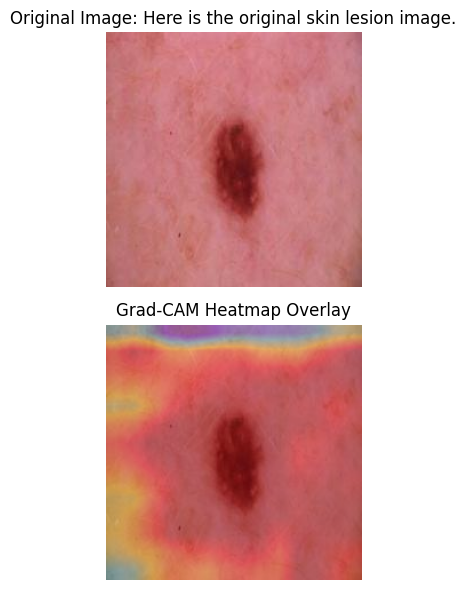

Generating Grad-CAMs:  90%|█████████ | 9/10 [00:04<00:00,  2.28it/s]

Heatmap Overlaid on Image: "The model focused on these areas (in red/yellow) to make its prediction."
Explanation: "The model predicts this lesion as Benign with a confidence of 90.78%. The red regions represent areas that the model believes to be most indicative of benign tissue. These areas may correspond to the irregular texture, shape, or color associated with cancerous tissue."
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


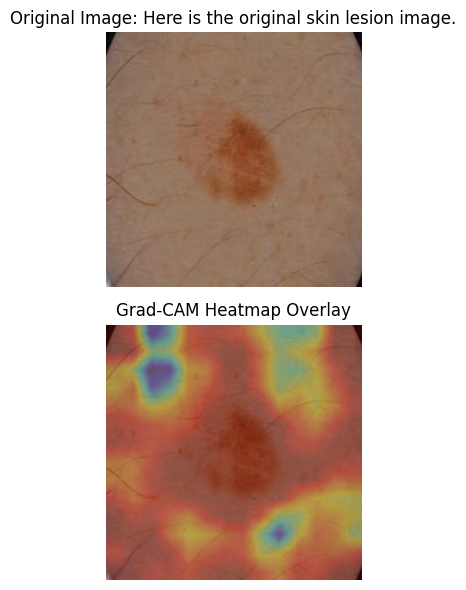

Generating Grad-CAMs: 100%|██████████| 10/10 [00:04<00:00,  2.22it/s]

Heatmap Overlaid on Image: "The model focused on these areas (in red/yellow) to make its prediction."
Explanation: "The model predicts this lesion as Benign with a confidence of 58.33%. The red regions represent areas that the model believes to be most indicative of benign tissue. These areas may correspond to the irregular texture, shape, or color associated with cancerous tissue."

✅ Grad-CAM explanations generated and displayed successfully.


In [ ]:
# --------- Grad-CAM Implementation ---------
print("\n" + "="*50)
print("--- Starting Grad-CAM Explanations ---")
print("="*50 + "\n")

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """
    Generates Grad-CAM heatmap for a given image and model.
    Args:
        img_array: Preprocessed image array (batch of 1: (1, H, W, C)).
        model: Trained Keras model.
        last_conv_layer_name: Name of the last convolutional layer in the base model.
        pred_index: Optional. If specified, computes heatmap for this class.
                    Otherwise, computes for the top predicted class.
    Returns:
        Numpy array representing the heatmap or None if gradient is None.
    """
    input_layer = model.layers[0].input
    # Get the VGG16 base model layer
    vgg_base_model = model.get_layer('vgg16')
    last_conv_layer_output = vgg_base_model.get_layer(last_conv_layer_name).output

    x = last_conv_layer_output
    for layer in model.layers[1:]:
        x = layer(x)
    final_output = x

    grad_model = tf.keras.models.Model(
        inputs=input_layer,
        outputs=[last_conv_layer_output, final_output]
    )

    img_array = tf.cast(img_array, tf.float32)

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)

        if pred_index is None:
            pred_index = tf.argmax(predictions[0])

        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)

    if grads is None:
        print("Gradient is None. Returning None for heatmap.")
        return None

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + tf.keras.backend.epsilon())

    heatmap = tf.cast(heatmap, tf.float32)
    return heatmap.numpy()

# =================== Grad-CAM Visualization Loop ===================
idx_to_class = {v: k for k, v in test_generator.class_indices.items()}

# Get all true labels and predicted labels from the test set
test_true_labels = test_generator.classes
test_pred_labels = np.argmax(model.predict(test_generator), axis=1) # Ensure this is run once

# Separate indices for correct and incorrect predictions
correctly_classified_indices = np.where(test_true_labels == test_pred_labels)[0]
misclassified_indices = np.where(test_true_labels != test_pred_labels)[0]

num_samples_to_visualize_gradcam = 10 # Total number of Grad-CAM samples
sample_indices_gradcam = []

# Prioritize misclassified samples for Grad-CAM
num_misclassified_to_pick = min(num_samples_to_visualize_gradcam // 2, len(misclassified_indices))
num_correct_to_pick = min(num_samples_to_visualize_gradcam - num_misclassified_to_pick, len(correctly_classified_indices))

sample_indices_gradcam.extend(random.sample(list(misclassified_indices), num_misclassified_to_pick))
sample_indices_gradcam.extend(random.sample(list(correctly_classified_indices), num_correct_to_pick))
random.shuffle(sample_indices_gradcam)

print(f"Attempting to visualize {len(sample_indices_gradcam)} images with Grad-CAM (prioritizing misclassified).")

# VGG16's last convolutional layer. This is typically 'block5_conv3'.
last_conv_layer_name = 'block5_conv3'

for i in tqdm(sample_indices_gradcam, desc="Generating Grad-CAMs"): # Use tqdm for progress bar
    img_path = test_generator.filepaths[i]
    img_array_preprocessed, img_rgb_resized, img_rgb_original_full_size = load_and_preprocess_single_image(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))

    if img_array_preprocessed is None:
        print(f"Could not read image at {img_path}. Skipping for Grad-CAM.")
        continue

    original_height, original_width = img_rgb_original_full_size.shape[:2]

    # Get model's predicted class and confidence for this image
    predicted_probs = model.predict(img_array_preprocessed)
    predicted_class_idx = np.argmax(predicted_probs[0])
    predicted_class_label = idx_to_class[predicted_class_idx]
    confidence = predicted_probs[0][predicted_class_idx] * 100 # Convert to percentage

    # Generate heatmap for the predicted class
    heatmap = make_gradcam_heatmap(img_array_preprocessed, model, last_conv_layer_name, pred_index=predicted_class_idx)

    if heatmap is not None:
        heatmap_resized = cv2.resize(heatmap, (original_width, original_height))
        heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)

        # Superimpose the heatmap on the original image (adjust alpha for better visibility)
        superimposed_img = cv2.addWeighted(img_rgb_original_full_size, 0.7, heatmap_colored, 0.3, 0)

        plt.figure(figsize=(12, 6))
        plt.subplot(2, 1, 1) # Changed to 2 rows, 1 column for better text placement
        plt.imshow(img_rgb_original_full_size)
        plt.title("Original Image: Here is the original skin lesion image.")
        plt.axis('off')

        plt.subplot(2, 1, 2) # Changed to 2 rows, 1 column
        plt.imshow(superimposed_img)
        plt.title("Grad-CAM Heatmap Overlay")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

        print(f'Heatmap Overlaid on Image: "The model focused on these areas (in red/yellow) to make its prediction."')
        print(f'Explanation: "The model predicts this lesion as {predicted_class_label} with a confidence of {confidence:.2f}%. '
              f'The red regions represent areas that the model believes to be most indicative of {predicted_class_label.lower()} tissue. '
              f'These areas may correspond to the irregular texture, shape, or color associated with cancerous tissue."')
        plt.pause(0.1)
    else:
        print(f"Could not generate Grad-CAM for image at index {i}.")

print("\n✅ Grad-CAM explanations generated and displayed successfully.")




--- Starting SHAP Explanations (Updated Visualization Logic) ---

✅ SHAP explanations generated and displayed successfully.

--- Starting SHAP Explanation (Display Mode) for 10 images ---


Background dataset shape for SHAP: (50, 224, 224, 3)
Selected 10 test images for SHAP (5 Benign, 5 Malignant).


Preparing test images for SHAP: 100%|██████████| 10/10 [00:00<00:00, 255.39it/s]
/usr/local/lib/python3.11/dist-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(


Preprocessed test images shape for SHAP: (10, 224, 224, 3)
Initializing SHAP DeepExplainer...
Calculating SHAP values for 10 test images... (this may take a while)


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_19
Received: inputs=['Tensor(shape=(100, 224, 224, 3))']
  warnings.warn(msg)


Generating SHAP plots...


Displaying SHAP plots:   0%|          | 0/10 [00:00<?, ?it/s]

<Figure size 1000x500 with 0 Axes>

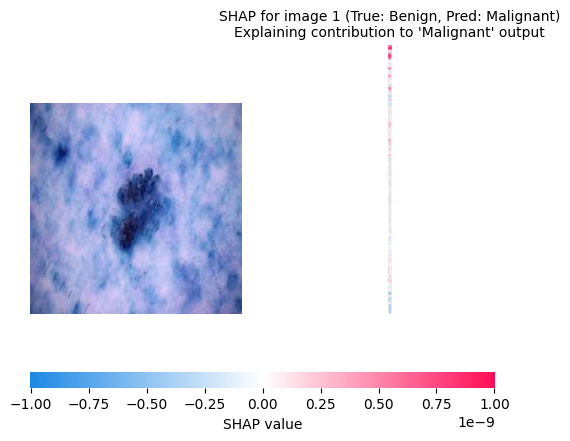

Displaying SHAP plots:  10%|█         | 1/10 [00:00<00:01,  6.21it/s]

<Figure size 1000x500 with 0 Axes>

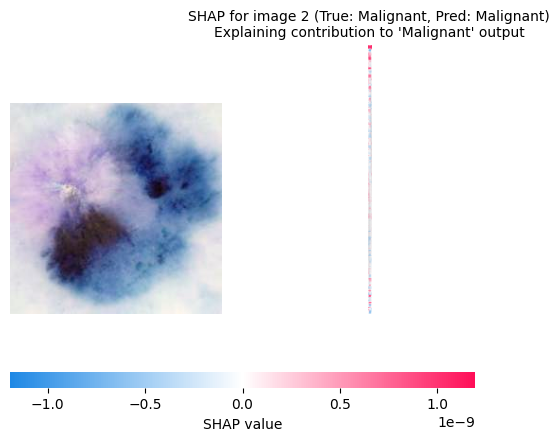

Displaying SHAP plots:  20%|██        | 2/10 [00:00<00:01,  6.45it/s]

<Figure size 1000x500 with 0 Axes>

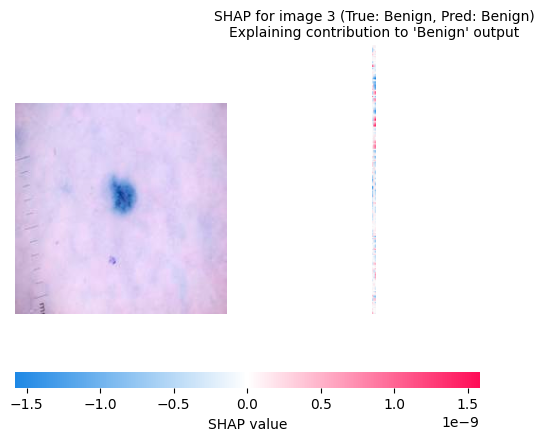

Displaying SHAP plots:  30%|███       | 3/10 [00:00<00:01,  6.47it/s]

<Figure size 1000x500 with 0 Axes>

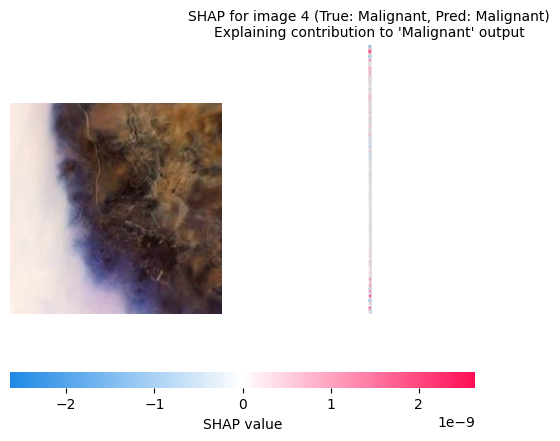

Displaying SHAP plots:  40%|████      | 4/10 [00:00<00:00,  6.61it/s]

<Figure size 1000x500 with 0 Axes>

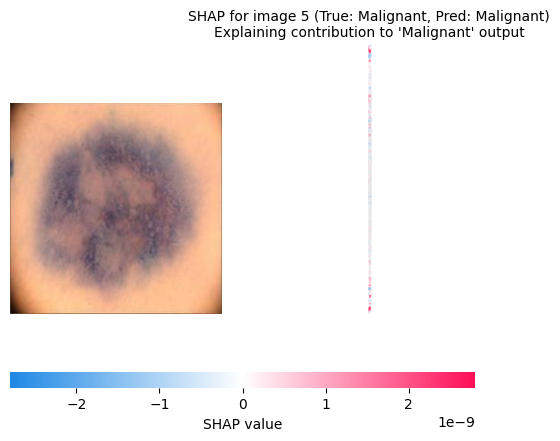

Displaying SHAP plots:  50%|█████     | 5/10 [00:00<00:00,  6.57it/s]

<Figure size 1000x500 with 0 Axes>

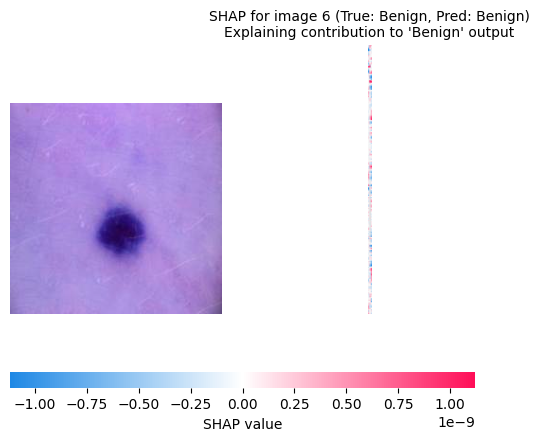

Displaying SHAP plots:  60%|██████    | 6/10 [00:00<00:00,  6.52it/s]

<Figure size 1000x500 with 0 Axes>

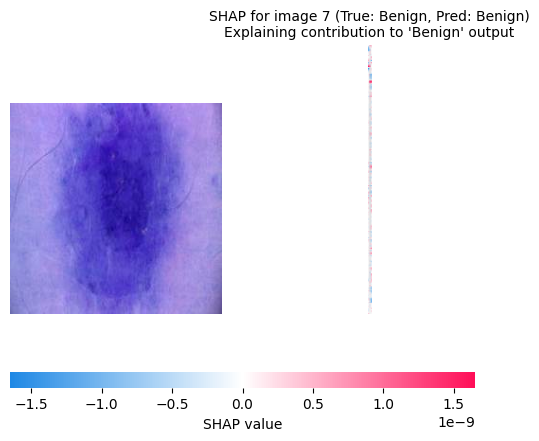

Displaying SHAP plots:  70%|███████   | 7/10 [00:01<00:00,  6.48it/s]

<Figure size 1000x500 with 0 Axes>

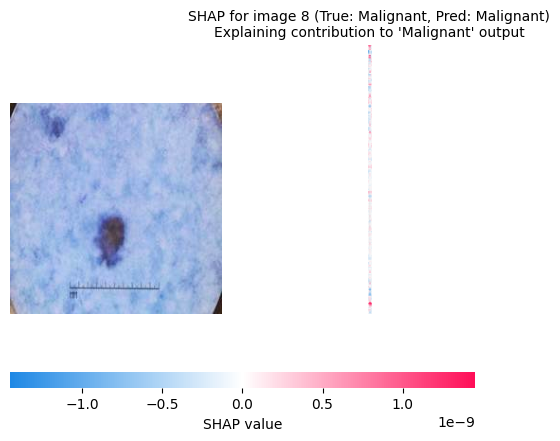

Displaying SHAP plots:  80%|████████  | 8/10 [00:01<00:00,  6.46it/s]

<Figure size 1000x500 with 0 Axes>

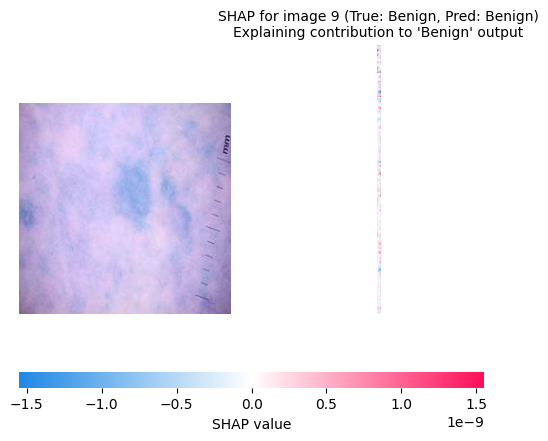

Displaying SHAP plots:  90%|█████████ | 9/10 [00:01<00:00,  6.44it/s]

<Figure size 1000x500 with 0 Axes>

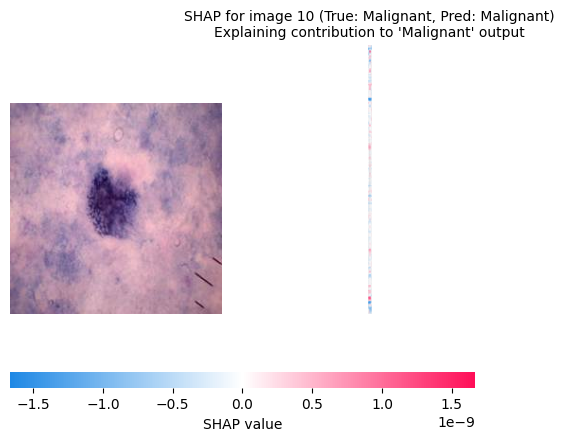

Displaying SHAP plots: 100%|██████████| 10/10 [00:01<00:00,  6.47it/s]



Generating SHAP Summary Plot for global feature importance across test images (Malignant Class)...


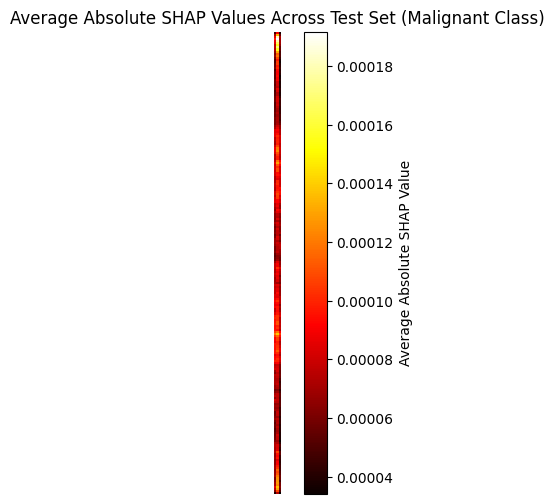

In [ ]:
# ==============================================================================
# --- SHAP Explanation Code Integration (Updated for better visualization) ---
# ==============================================================================

print("\n" + "="*50)
print("--- Starting SHAP Explanations (Updated Visualization Logic) ---")
print("="*50 + "\n")

# Make sure y_true from your model evaluation is accessible here.
# It's usually a global variable after the evaluation section:
# y_true = test_generator.classes

def explain_with_shap(model: tf.keras.Model, background_generator, test_generator,
                      y_true_test_set: np.ndarray,
                      num_background: int = 50, num_test_total: int = 5):
    """
    Generates and displays SHAP explanations for test images using a trained model.
    It attempts to select a balanced set of images (Benign/Malignant) for explanation.
    Each image's explanation will be for the class that the model predicted for that image.
    Attempts to ensure SHAP values overlay the image.

    Args:
        model: Trained Keras model.
        background_generator: Data generator for selecting background images (e.g., train_generator).
                              Expected to yield (images, labels) batches.
        test_generator: Data generator containing test images.
                        Expected to yield (images, labels) batches.
        y_true_test_set (np.ndarray): The true labels for the test set. This should be
                                      `test_generator.classes` obtained after `test_generator.reset()`.
        num_background: Number of background images for SHAP baseline. Defaults to 50.
        num_test_total: Total number of test images to explain (attempting a mix of classes).
    """
    print(f"\n--- Starting SHAP Explanation (Display Mode) for {num_test_total} images ---")

    # Step 1: Select background dataset
    background_images = []
    background_generator.reset()
    try:
        collected_batches = 0
        gen_len = len(background_generator) # Get generator length for safety
        # Use tqdm for background image collection
        for _ in tqdm(range(gen_len), desc="Collecting background images"):
            if len(background_images) >= num_background:
                break
            batch_images, _ = next(background_generator)
            background_images.extend(batch_images)
            collected_batches += 1
    except StopIteration:
        print("Warning: Background generator exhausted before reaching desired number of samples.")

    background_images = np.array(background_images[:num_background])
    if background_images.shape[0] == 0:
        print("Error: No background images collected for SHAP baseline. Exiting SHAP explanation.")
        return
    print(f"Background dataset shape for SHAP: {background_images.shape}")

    # Step 2: Select a balanced set of test images for explanation
    test_images_for_shap = []
    true_labels_for_shap_indices = [] # Store indices, not one-hot, for simpler lookup

    class_names_map = {v: k for k, v in test_generator.class_indices.items()}
    # Ensure these keys exist, or provide defaults
    benign_class_idx = test_generator.class_indices.get('Benign', 0)
    malignant_class_idx = test_generator.class_indices.get('Malignant', 1)

    # Filter indices based on true labels from the passed y_true_test_set
    benign_test_indices = np.where(y_true_test_set == benign_class_idx)[0]
    malignant_test_indices = np.where(y_true_test_set == malignant_class_idx)[0]

    num_benign_to_pick = min(num_test_total // 2, len(benign_test_indices))
    num_malignant_to_pick = min(num_test_total - num_benign_to_pick, len(malignant_test_indices))

    selected_indices = []
    selected_indices.extend(random.sample(list(benign_test_indices), num_benign_to_pick))
    selected_indices.extend(random.sample(list(malignant_test_indices), num_malignant_to_pick))
    random.shuffle(selected_indices)

    if not selected_indices:
        print("Error: No suitable test images (Benign/Malignant) found for SHAP explanation. Exiting.")
        return

    print(f"Selected {len(selected_indices)} test images for SHAP ({num_benign_to_pick} Benign, {num_malignant_to_pick} Malignant).")

    for idx in tqdm(selected_indices, desc="Preparing test images for SHAP"):
        img_path = test_generator.filepaths[idx]
        img = cv2.imread(img_path)
        if img is None:
            print(f"Could not read image at {img_path}. Skipping for SHAP.")
            continue
        # Resize and convert to RGB
        img_rgb = cv2.cvtColor(cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH)), cv2.COLOR_BGR2RGB)
        # Preprocess for model input (VGG16's preprocess_input)
        test_images_for_shap.append(preprocess_input(img_rgb))
        # Store the true label index
        true_labels_for_shap_indices.append(y_true_test_set[idx])

    test_images_for_shap = np.array(test_images_for_shap)
    true_labels_for_shap_indices = np.array(true_labels_for_shap_indices)

    if test_images_for_shap.shape[0] == 0:
        print("Error: No preprocessed test images collected for SHAP explanation. Exiting.")
        return
    print(f"Preprocessed test images shape for SHAP: {test_images_for_shap.shape}")


    # Step 3: Initialize SHAP DeepExplainer
    print("Initializing SHAP DeepExplainer...")
    explainer = shap.DeepExplainer(model, background_images)

    # Step 4: Compute SHAP values for test images
    print(f"Calculating SHAP values for {test_images_for_shap.shape[0]} test images... (this may take a while)")
    # Using tqdm with explainer.shap_values for progress feedback
    shap_values_all_classes = explainer.shap_values(test_images_for_shap)


    # Step 5: Visualise explanations
    print("Generating SHAP plots...")
    for i in tqdm(range(test_images_for_shap.shape[0]), desc="Displaying SHAP plots"):
        plt.figure(figsize=(10, 5))

        # Determine the model's predicted class for this specific image
        # Expand dims for single image prediction
        predicted_probs = model.predict(np.expand_dims(test_images_for_shap[i], axis=0), verbose=0) # Suppress prediction output
        predicted_class_idx = np.argmax(predicted_probs[0])

        # Use the predicted class as the target for explanation
        explanation_target_class = predicted_class_idx

        if explanation_target_class < len(shap_values_all_classes):
            # The SHAP values for this specific image and target class
            current_image_shap_values = shap_values_all_classes[explanation_target_class][i]

            # Normalise the image for display (from model's [-1,1] or [0,1] range to [0,1])
            display_image = test_images_for_shap[i].copy()
            # If preprocess_input scales to [-1, 1], convert to [0, 1] for display
            display_image = (display_image - display_image.min()) / (display_image.max() - display_image.min() + 1e-8)
            display_image = np.clip(display_image, 0, 1) # Ensure values are strictly within 0-1

            # Ensure current_image_shap_values is 4D (batch_size=1) for shap.image_plot
            if current_image_shap_values.ndim == 3: # If it's (H, W, C)
                current_image_shap_values = np.expand_dims(current_image_shap_values, axis=0)
            elif current_image_shap_values.ndim == 2: # If it's (H, W), expand to (1, H, W, 1)
                current_image_shap_values = np.expand_dims(current_image_shap_values, axis=(0, -1))

            shap.image_plot(
                current_image_shap_values, # Pass the 4D SHAP values (1, H, W, C)
                np.expand_dims(display_image, axis=0), # Pass the 4D image (1, H, W, C)
                show=False, # We'll call plt.show() explicitly
            )

            true_class_idx = true_labels_for_shap_indices[i] # Use the stored true index

            true_class_name = class_names_map.get(true_class_idx, f"Class {true_class_idx}")
            predicted_class_name = class_names_map.get(predicted_class_idx, f"Class {predicted_class_idx}")
            explanation_class_name = class_names_map.get(explanation_target_class, f"Class {explanation_target_class}")


            plt.title(f"SHAP for image {i+1} (True: {true_class_name}, Pred: {predicted_class_name})\n"
                      f"Explaining contribution to '{explanation_class_name}' output", fontsize=10)
            plt.show()
        else:
            print(f"Warning: Explanation target class {explanation_target_class} is out of bounds for model outputs for image {i+1}.")
            plt.close() # Close empty figure


    # Step 6: Generate SHAP Summary Plot for global feature importance
    print("\nGenerating SHAP Summary Plot for global feature importance across test images (Malignant Class)...")

    try:
        # Convert test_images_for_shap to float32 for SHAP plotting if needed
        test_images_for_shap_float32 = test_images_for_shap.astype(np.float32)

        # Using the computed shap_values_all_classes from DeepExplainer
        # For a summary plot of feature importance across pixels, we can average the absolute
        # SHAP values across the samples to get a sense of which pixel locations are
        # generally important, regardless of the specific image.

        # Generate summary plot for the 'Malignant' class (index 1)
        shap_values_malignant = shap_values_all_classes[1] # Shape: (num_samples, height, width, channels)
        mean_abs_shap_values_malignant = np.mean(np.abs(shap_values_malignant), axis=(0, 3)) # Average over samples and channels

        plt.figure(figsize=(6, 6))
        plt.imshow(mean_abs_shap_values_malignant, cmap='hot', interpolation='nearest')
        plt.title('Average Absolute SHAP Values Across Test Set (Malignant Class)')
        plt.colorbar(label='Average Absolute SHAP Value')
        plt.axis('off')
        plt.show()


    except Exception as e:
        print(f"An error occurred while generating the SHAP summary plot: {e}")


print("✅ SHAP explanations generated and displayed successfully.")

# --- Call SHAP explanation function ---
# Ensure y_true is populated before calling SHAP functions
# This line should ideally be placed right after your model.evaluate() or
# after the confusion matrix calculation where test_generator.classes is accessed.
# Example:
# test_generator.reset()
# y_pred_probs = model.predict(test_generator)
# y_pred = np.argmax(y_pred_probs, axis=1)
# y_true_test_set = test_generator.classes # Define y_true_test_set here!

# Call the SHAP explanation function after model evaluation
# The `y_true` variable from the evaluation section is passed here.
explain_with_shap(model, train_generator, test_generator, y_true_test_set=y_true,
                  num_background=50, num_test_total=10) # Adjusted num_test_total for SHAP for faster execution if needed